# Finetuning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import torch
import tqdm
from pandas.api.types import CategoricalDtype

## Connect to drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%ls

drive/  sample_data/


In [4]:
%cd drive/MyDrive/reflection-classification/

/content/drive/MyDrive/reflection-classification


In [5]:
%ls

analyses/  LICENSE  README.md                   scripts/  test-trainer/
data/      models/  reflection_classification/  setup.py  test_trainer/


## Import dataset

In [6]:
# import sentences
sentences_en_tr = pd.read_csv('./data/sentences/en/train/sentences.tsv',sep='\t')
sentences_en_val = pd.read_csv('./data/sentences/en/val/sentences.tsv',sep='\t')
sentences_en_te = pd.read_csv('./data/sentences/en/test/sentences.tsv',sep='\t')
print(f'In English\nLenght training set : {len(sentences_en_tr)}')
print(f'Lenght validation set : {len(sentences_en_val)}')
print(f'Lenght testing set : {len(sentences_en_te)}')

sentences_en_te.head()

In English
Lenght training set : 6096
Lenght validation set : 339
Lenght testing set : 339


,idx,context,sentence,y,confidence,y_requires_context
0,1139,"Some struggled with it a bit, but even that is...",A few days ago I taught a class of seventh gra...,Experience,"[6, 3]",NaN
1,3566,The student with LMR had an assistant in the c...,had a very good feeling about some of the chil...,Feeling,"[5, 5]",NaN
2,6104,C prepared that it was perhaps the worst class...,"They had a teacher from civics who, among othe...",Other,"[6, 7]",NaN
3,8,"But I came and ruined everything. In addition,...","Of the lessons learned, this one was the most ...",Difficulties,"[4, 5]",K
4,2290,The teacher told me that she is happy about it...,"I have a good feeling about the teacher, you c...",Feeling,"[5, 4]",NaN


In [7]:
!pip install transformers[torch]
!pip install accelerate -U  # restart runtime if it still doesn't work
!pip install datasets
!pip install evaluate

 ## Finetuning on CERED dataset with custom training loop

 with small BERT

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
import numpy as np
import pandas as pd
import torch
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [17]:
# functions :
#   - preprocess_data
#   - prepare_model
#   - train
#   - evalaute

def preprocess_data(df_sentences):
  data = pd.DataFrame()
  data['text'] = df_sentences['sentence']
  data['label'] = df_sentences['y']

  # Preprocess data and labels
  tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

  max_length = max(data['text'].apply(lambda sentence: len(sentence.split())))

  data['text'] = data['text'].apply(
      lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length))

  label_encoder = LabelEncoder()
  data['label'] = label_encoder.fit_transform(data['label'])

  # Split the data into training and validation sets
  train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

  # Create a custom dataset
  class CustomDataset(Dataset):
      def __init__(self, text, label):
          self.text = text
          self.label = label
      def __len__(self):
          return len(self.text)
      def __getitem__(self, idx):
          return {
              'text': torch.tensor(self.text[idx], dtype=torch.long),
              'label': torch.tensor(self.label[idx], dtype=torch.long)
          }
  train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
  val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)

  return train_dataset, val_dataset, label_encoder

def prepare_model(model, freeze_weights, batch_size, epochs, learning_rate):

  if freeze_weights:
    # Freeze all layers except the last two
    for param in model.parameters():
      param.requires_grad = False
    for param in model.classifier.parameters():
      param.requires_grad = True

  # Create data loaders
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)

  # Set up optimizer and scheduler
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

  return train_loader, val_loader, optimizer, scheduler

def train(model, train_loader, epochs, optimizer, scheduler, plot_loss, device):
  train_losses = []

  for epoch in range(epochs):
      print(f"epoch {epoch} running...")
      model.train()
      train_loss = []

      for batch in train_loader:
          optimizer.zero_grad()
          inputs = batch['text'].to(device)
          labels = batch['label'].to(device)
          outputs = model(inputs, labels=labels)
          loss = outputs.loss
          train_loss.append(loss.item())
          loss.backward()
          optimizer.step()
          scheduler.step()

      avg_epoch_loss = sum(train_loss) / len(train_loss)
      train_losses.append(avg_epoch_loss)

  if plot_loss == True:
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

def evaluate(model, val_loader, label_encoder, device, plot_classification_report, plot_confusion_matrix):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
      for batch in val_loader:
          inputs = batch['text'].to(device)
          labels = batch['label'].to(device)
          outputs = model(inputs)
          predictions = torch.argmax(outputs.logits, axis=1)
          all_preds.extend(predictions.cpu().numpy().tolist())
          all_labels.extend(labels.tolist())

  # Decode label encodings
  predicted_labels = label_encoder.inverse_transform(all_preds)
  true_labels = label_encoder.inverse_transform(all_labels)

  if plot_classification_report:
    # Generate classification report
    report = classification_report(true_labels, predicted_labels, zero_division = 1)
    print(report)

  if plot_confusion_matrix:
    cm = confusion_matrix(true_labels, predicted_labels)
    class_labels = df_sentences['y'].unique()

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [18]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('./data/sentences/en/val/sentences.tsv',sep='\t')

train_dataset, val_dataset, label_encoder = preprocess_data(df_sentences)

# Initialize the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

# Define training parameters
batch_size, epochs, learning_rate = 1, 5, 2e-5
freeze_weights = False

train_loader, val_loader, optimizer, scheduler = prepare_model(model, freeze_weights, batch_size, epochs, learning_rate)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...


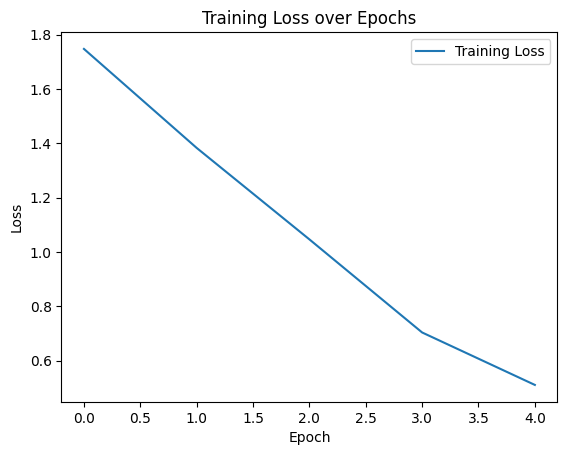

In [19]:
# train model
train(model = model,
      train_loader = train_loader,
      epochs = epochs,
      optimizer = optimizer,
      scheduler = scheduler,
      device = device,
      plot_loss = True)

              precision    recall  f1-score   support

      Belief       0.25      0.33      0.29         3
  Difficulty       0.00      0.00      0.00         3
  Experience       0.67      0.73      0.70        22
     Feeling       0.58      0.70      0.64        10
       Other       0.90      0.75      0.82        24
  Reflection       0.43      0.50      0.46         6

    accuracy                           0.66        68
   macro avg       0.47      0.50      0.48        68
weighted avg       0.67      0.66      0.66        68



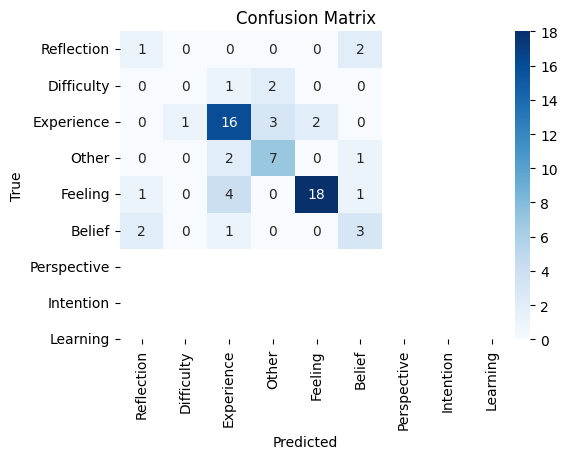

In [20]:
# evaluate model
evaluate(model = model,
         val_loader = val_loader,
         label_encoder = label_encoder,
         device = device,
         plot_classification_report = True,
         plot_confusion_matrix = True)

 ## Finetuning on CERED dataset with Trainer

 with small BERT

In [ ]:
import pandas as pd
import numpy as np
import torch
import evaluate
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
import lightning as L

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df_sentences_tr = pd.read_csv('./data/sentences/en/test/sentences.tsv',sep='\t')
dataset_test = Dataset.from_pandas(df_sentences_tr[['sentence', 'y']])
dataset_test

Dataset({
    features: ['sentence', 'y'],
    num_rows: 339
})

In [ ]:
dataset_test[4]

{'sentence': 'No one in the choir room offered me a chair.', 'y': 'Experience'}

In [ ]:
df_sentences_tr = pd.read_csv('./data/sentences/en/test/sentences.tsv',sep='\t') #use te because smaller than tr
df_sentences_val = pd.read_csv('./data/sentences/en/val/sentences.tsv',sep='\t')

# encode the labels
label_encoder = LabelEncoder()
df_sentences_tr['label_encoded'] = label_encoder.fit_transform(df_sentences_tr['y'])
df_sentences_val['label_encoded'] = label_encoder.fit_transform(df_sentences_val['y'])

# convert to Dataset to use the map function and Trainer
dataset_sentences_tr = Dataset.from_pandas(df_sentences_tr[['label_encoded', 'sentence']])
dataset_sentences_val = Dataset.from_pandas(df_sentences_val[['label_encoded', 'sentence']])

# Create a custom dataset
class df_to_dict(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label
    def __len__(self):
        return len(self.text)
    def __getitem__(self, idx):
        return {
            'text': self.text[idx],
            'label':self.label[idx]
        }

# dataset_tr = df_to_dict(dataset_sentences_tr['sentence'].values, df_sentences_tr['y'].values)
# dataset_val = df_to_dict(dataset_sentences_val['sentence'].values, df_sentences_val['y'].values)
# print(dataset_val[0])

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)


tokenized_dataset_tr = dataset_sentences_tr.map(tokenize_function, batched=True)
tokenized_dataset_val = dataset_sentences_val.map(tokenize_function, batched=True)

small_train_dataset = tokenized_dataset_tr.shuffle(seed=42).select(range(30))
small_eval_dataset = tokenized_dataset_val.shuffle(seed=42).select(range(30))

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

In [ ]:
# train
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

training_args = TrainingArguments(output_dir="test_trainer")

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: ignored

In [ ]:
trainer.train()

Train 8 binary classifiers

In [ ]:
data = pd.DataFrame(columns = ['text', 'label'])
# Load your data from data.csv
df_sentences = pd.read_csv('./data/sentences/en/val/sentences.tsv',sep='\t')
data['text'] = df_sentences['sentence']
data['label'] = df_sentences['y']

# Preprocess your data and labels
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

max_length = max(data['text'].apply(lambda sentence: len(sentence.split())))
print(f"max length of sentence in dataset : {max_length}")

data['text'] = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length))

#label_encoder = LabelEncoder()
#data['label'] = label_encoder.fit_transform(data['label'])
data['label'] = (data['label'] == 'Experience').astype(int)
print(data['label'].sum())

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label
    def __len__(self):
        return len(self.text)
    def __getitem__(self, idx):
        return {
            'text': torch.tensor(self.text[idx], dtype=torch.long),
            'label': torch.tensor(self.label[idx], dtype=torch.long)
        }
train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)

# Initialize 8 pre-trained BERT model
#binary_classifier = [AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) for _ in range(8)]
binary_classifier = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Freeze all layers except the last two
for param in binary_classifier.parameters():
    param.requires_grad = False
for param in binary_classifier.classifier.parameters():
    param.requires_grad = True

# Define training parameters
batch_size = 32
epochs = 1
learning_rate = 2e-5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(binary_classifier.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

max length of sentence in dataset : 88
90


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
for epoch in range(epochs):
    print(f"epoch {epoch} running...")
    binary_classifier.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch['text'].to(device)
        labels = batch['label'].to(device)
        outputs = binary_classifier(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

epoch 0 running...


In [ ]:
# Validation loop
binary_classifier.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['text'].to(device)
        labels = batch['label'].to(device)
        outputs = binary_classifier(inputs)
        predictions = torch.argmax(outputs.logits, axis=1)
        all_preds.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(labels.tolist())

# Decode label encodings
predicted_labels = label_encoder.inverse_transform(all_preds)
true_labels = label_encoder.inverse_transform(all_labels)

# Generate classification report
report = classification_report(true_labels, predicted_labels, zero_division = 1)
print(report)

              precision    recall  f1-score   support

      Belief       0.68      0.98      0.80        46
  Difficulty       0.50      0.05      0.08        22

    accuracy                           0.68        68
   macro avg       0.59      0.51      0.44        68
weighted avg       0.62      0.68      0.57        68



Customized model with additional layers

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and preprocess your data
# ...

# Initialize tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9)  # 9 categories

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return {
            'text': self.text[idx],
            'label': self.label[idx]
        }

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Create data loaders
batch_size = 32
train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# Training loop
epochs = 5  # Adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        labels = batch['label'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()


## Eval of RoBERTa model (too big to train - 500M + parameters)

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

LABELS = ["Other", "Belief", "Perspective", "Feeling", "Experience",
          "Reflection", "Difficulty", "Intention", "Learning"]

class NeuralClassifier:

    def __init__(self, model_path: str, uses_context: bool, device: str):
        self.config = AutoConfig.from_pretrained(model_path)
        self.device = device
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path, config=self.config).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.uses_context = uses_context

    def predict_sentence(self, sentence: str, context: str = None):
        if context is None and self.uses_context:
            raise ValueError("You need to pass in context argument, including the sentence")

        features = self.tokenizer(sentence, text_pair=context,
                                  padding="max_length", truncation=True, return_tensors='pt')
        outputs = self.model(**features.to(self.device), return_dict=True)
        argmax = outputs.logits.argmax(dim=-1).detach().cpu().tolist()[0]
        labels = LABELS[argmax]

        return labels

In [ ]:
# load the pretrained model from Hugging Face
classifier = NeuralClassifier(model_path="MU-NLPC/XLM-R-large-reflective-conf4",
                              uses_context=False,
                              #device="cpu")
                              device=device)

In [ ]:
# evaluation on the test dataset (~ 1min on GPU, > 20 min on cpu)
labels = sentences_en_te['y'].values
predictions = []

for idx, sentence in enumerate(sentences_en_te['sentence']):
    predictions.append(classifier.predict_sentence(sentence))
    if (idx%30) == 0:
        print(f'{np.round(100*(idx+1)/len(sentences_en_te["sentence"]),3)} % labeled')

print(predictions)

0.295 % labeled
9.145 % labeled
17.994 % labeled
26.844 % labeled
35.693 % labeled
44.543 % labeled
53.392 % labeled
62.242 % labeled
71.091 % labeled
79.941 % labeled
88.791 % labeled
97.64 % labeled
['Experience', 'Other', 'Experience', 'Other', 'Experience', 'Experience', 'Other', 'Reflection', 'Difficulty', 'Reflection', 'Experience', 'Reflection', 'Experience', 'Other', 'Feeling', 'Experience', 'Other', 'Other', 'Experience', 'Difficulty', 'Other', 'Other', 'Other', 'Other', 'Feeling', 'Feeling', 'Other', 'Belief', 'Experience', 'Experience', 'Other', 'Feeling', 'Experience', 'Other', 'Other', 'Reflection', 'Feeling', 'Difficulty', 'Experience', 'Feeling', 'Experience', 'Experience', 'Other', 'Feeling', 'Experience', 'Other', 'Feeling', 'Experience', 'Other', 'Experience', 'Perspective', 'Feeling', 'Experience', 'Feeling', 'Other', 'Other', 'Reflection', 'Other', 'Other', 'Feeling', 'Other', 'Feeling', 'Feeling', 'Feeling', 'Perspective', 'Feeling', 'Feeling', 'Feeling', 'Difficul

In [ ]:
print(f'Accuracy : {accuracy_score(labels,predictions)}')

Accuracy : 0.7286135693215339
